# Pendulum on a Cart - LQR

## Objectives

1.  Derive the linearized equations of motion for a pendulum on a cart dynamics.
2.  Design LQR controller to stabilize the hanging equilibrium

## Python Control System Toolbox


In [ ]:
pip install control

## Pendulum on Cart

Consider a pendulum on a cart model as illustrated below.

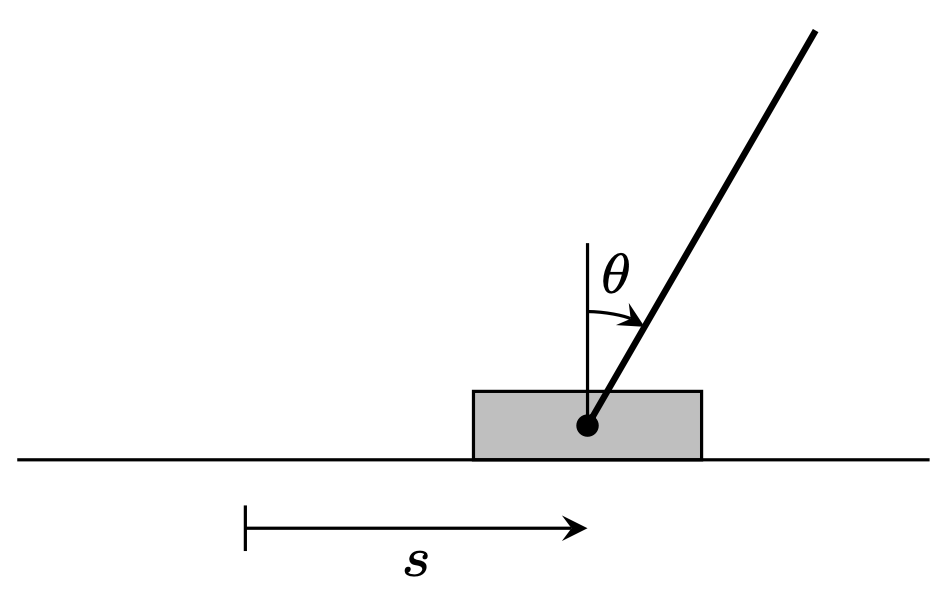

### Equations of Motion

After non-dimensionalizing the variables and the time, the equations of motion can be written as

\begin{align*}
\ddot \theta & = \frac{1}{1+c\sin^2\theta}(-c\dot\theta^2\sin\theta\cos\theta + \sin\theta - \cos\theta u),\\
\ddot s & = \frac{1}{1+c\sin^2\theta}( (1+c)\dot\theta^2 - \sin\theta\cos\theta + b u),
\end{align*}
where $b, c\in\Re$ are constant parameters that can be determined by the mass and length properties, and $u\in\Re$ is the control force acting on the cart.

### State Variables

Let the state variables $x\in\Re^4$ and the output variable $y\in\Re^4$ be

\begin{align*}
x & = [x_1, x_2, x_3, x_3] = [\theta, \dot\theta, s, \dot s],\\
 y & = x
\end{align*}

### Nonlinear State Equation

In the modeling, the equations of motion are reformulated in to the state equation, given by $\dot x = f (t, x, u)$ and $y=g(t,x,u)$. 

This can be formulated in python by [control.NonlinearIOSystem()](https://python-control.readthedocs.io/en/0.9.4/generated/control.NonlinearIOSystem.html#control.NonlinearIOSystem) with the usuage of

```control.NonlinearIOSystem(updfcn, outfcn=None, params=None, **kwargs)```

where 

* `updfcn(t, x, u, params)` is a python function for $f(t,x,u)$ with an additional parameter
* `outfcn(t, x, u, params)` is a python function for $g(t,x,u)$ with an additional parameter

Suppose $b=3$ and $c=0.5$.
Complete the following code to define a python model for the pendulum on car, as we did in Recitation 2.

**NOTE**: In the above functions, `updfcn`, `outfcn`, it is considered that both of `x` and `u` are array-like. Consequently, the input must be referenced as `u[0]` inside of the function, insteand of `u`.



In [ ]:
import control
import numpy as np
import matplotlib.pyplot as plt

params = {"b": 3., "c": 0.5}
def pendulum_cart_eom(t, x, u, params):
    b = params['b']
    c = params['c']

    theta, theta_dot, s, s_dot = x[0], x[1], x[2], x[3]

    theta_ddot = (-c*theta_dot**2*np.sin(theta)*np.cos(theta)+np.sin(theta)-np.cos(theta)*u[0])/(1+c*np.sin(theta)**2)
    s_ddot = ((1+c)*theta_dot**2 - np.sin(theta)*np.cos(theta) + b*u[0])/(1+c*np.sin(theta)**2)

    x_dot = np.array([theta_dot, theta_ddot, s_dot, s_ddot])
    
    return x_dot

def pendulum_cart_output(t, x, u, params):
    return x

# define a nonlinear dynamic model (the second and the third lines are optional)
sys_pendulum_cart = control.NonlinearIOSystem(updfcn = pendulum_cart_eom, outfcn=pendulum_cart_output, \
                                         states=('angle', 'angular_velocity', 'position', 'velocity'), \
                                         output=('angle', 'angular velocity', 'position', 'velocity'), inputs=('force'), \
                                         name='pendulum_cart')

print(sys_pendulum_cart)


### Linearization

The hanging equililbrium is given by 

\begin{align*}
x^* = [\pi, 0, 0, 0],\quad u^*=0.
\end{align*}

Find the linearized equations of motion, or the linear state-spade model using [control.linearize()](https://python-control.readthedocs.io/en/latest/generated/control.linearize.html). 

Print out the matrices $A,B,C$ and $D$ and verity that they are close to

\begin{gather*}
A = \begin{bmatrix}
0 & 1 & 0 & 0 \\
-1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
-1 & 0 & 0 & 0
\end{bmatrix}, 
\quad
B = \begin{bmatrix} 0 \\ 1 \\ 0 \\ 3 \end{bmatrix},\\
C = I_{4\times 4}, \quad D=0_{4\times 1}
\end{gather*}


In [ ]:
x_star = np.array([np.pi, 0., 0., 0.])
u_star = [0]

syslin_pendulum_cart = control.linearize(sys_pendulum_cart, x_star, u_star, params=params)
print(syslin_pendulum_cart)



### Uncontrolled Dynamics

The uncontrolled dynamics from a given inital condition can be simulated by [`control.input_output_response()`](https://python-control.readthedocs.io/en/latest/generated/control.input_output_response.html).

Recall that the linearized dynamics simulates the perturbantion $\delta x = x - x^*$. Therefore, after simulting the linearized dynamcis to obtain $\delta x(t)$, it shold be converted back to the original state $x(t) = x^* + \delta x(t)$.

In [ ]:
t = np.linspace(0, 20, 501)
sim_data = control.input_output_response(syslin_pendulum_cart, T=t, X0=[np.pi/6, 0, 0, 0], params=params)
delta_x = sim_data.x
x = delta_x + x_star[:, None]


def plot_state(t,x):
    plt.figure(figsize=(5,8))
    ylabels = ['$\phi$', '$\dot\phi$', '$s$', '$\dot s$']
    for i in range(4):
        axi = plt.subplot(4, 1, i+1)
        axi.plot(t, x[i])
        axi.set_ylabel(ylabels[i])


%matplotlib inline
plot_state(t,x)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.animation as animation
import matplotlib.patches as patches

%matplotlib widget
def ani_pend_cart(x):
    phi = x[0] 
    s = x[2]
    print(phi.shape[0])

    # generate animation
    w = 0.6
    h = 0.1
    pw = 0.05
    ph = 1.5
    vertices0_cart = np.array([ [-w,h/2], [w, h/2], [w, -h/2], [-w, -h/2] ]).T
    vertices0_pend = np.array([ [-pw,ph], [pw, ph], [pw, 0], [-pw, 0] ]).T

    def compute_R(angle):
        return np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
    def compute_vertices(i):
        vertices_cart = vertices0_cart.copy()
        vertices_cart[0,:]+=s[i]
        vertices_pend = compute_R(phi[i]) @ vertices0_pend.copy()
        vertices_pend[0,:]+=s[i]
        return vertices_pend, vertices_cart

    vertices_pend, vertices_cart = compute_vertices(0)
    patch_cart = Polygon(vertices_cart.T, facecolor = 'b')
    patch_pend = Polygon(vertices_pend.T, facecolor = 'g')

    fig = plt.figure(figsize = (5,5))
    ax = plt.gca()
    ax.add_patch(patch_cart)
    ax.add_patch(patch_pend)
    text_t = ax.text(-0.2,-2, f't = {t[0]:.2f}')
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.axis('off')
    plt.show()

    def init():
        return patch_pend, patch_cart

    def animate(i):

        vertices_pend, vertices_cart = compute_vertices(i)
        patch_cart.set_xy(vertices_cart.T)
        patch_pend.set_xy(vertices_pend.T)
        text_t.set_text(f't = {t[i]:.2f}')
        return patch_pend, patch_cart

    ani = animation.FuncAnimation(fig, animate, phi.shape[0], init_func=init, interval=2, repeat=False)
    return ani

ani = ani_pend_cart(x)


## LQR Design

Choose $Q\in\Re^{4\times 4}$ and $R\in\Re^1$. Using the python function [`control.lqr`](https://python-control.readthedocs.io/en/latest/generated/control.lqr.html), find the gain matrix $K\in\Re^{4\times 1}$.

In [ ]:
Q = np.diag([1, 1, 1, 1])
R = 1

K, _, _ = control.lqr(syslin_pendulum_cart, Q, R)

print(K)

The controlled system can be defined by [`control.create_statefbk_iosystem`](https://python-control.readthedocs.io/en/latest/generated/control.create_statefbk_iosystem.html#control.create_statefbk_iosystem)

In [ ]:
ctrlin_lqr, syslin_lqr = control.create_statefbk_iosystem(syslin_pendulum_cart, K)

print(syslin_lqr)

t = np.linspace(0, 40, 1001)
sim_data = control.input_output_response(syslin_lqr, t, X0=[np.pi/3, 0, 0, 0])
delta_x = sim_data.x
x = delta_x + x_star[:, None]
u = sim_data.y[4]

%matplotlib inline
plot_state(t,x)
plt.figure(figsize=(5,2))
plt.plot(t,u)
plt.ylabel('u')



In [ ]:
%matplotlib widget
ani = ani_pend_cart(x)